In [1]:
!unzip \*.zip

Archive:  cell-images-for-detecting-malaria.zip
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
  inflating: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_138.png  
  inflating: cell

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

dir = "cell_images/cell_images"
listdir = os.listdir(dir)
Parasitized = os.listdir("cell_images/cell_images/Parasitized")
Uninfected = os.listdir("cell_images/cell_images/Uninfected")

print(listdir)
print(len(Parasitized))
print(len(Uninfected))

['Uninfected', 'Parasitized']
13780
13780


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Define your transforms for the training set

train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

train_set = datasets.ImageFolder(dir, transform=train_transforms)

In [31]:
#create dataset
test_size = 0.1
valid_size = 0.2
# obtain training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=32, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=53, 
    sampler=test_sampler)

5511 2756 19291


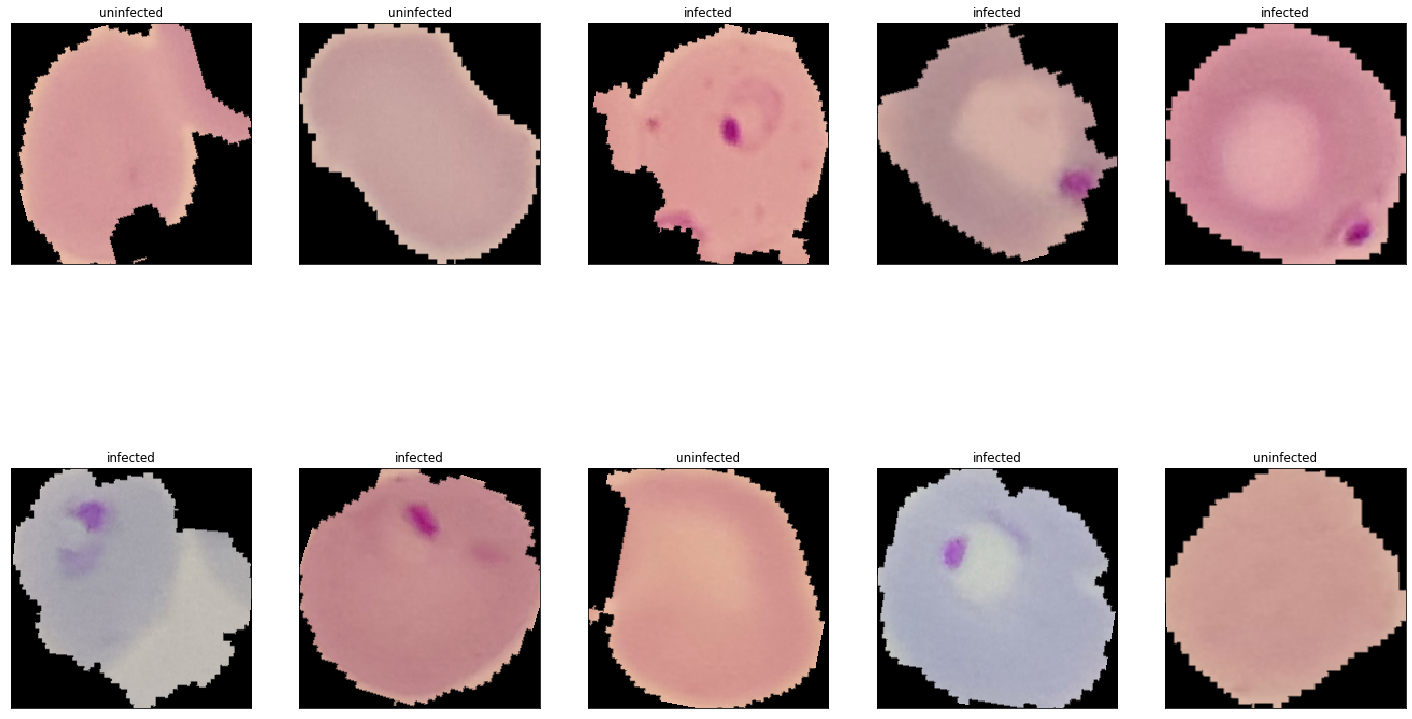

In [6]:
classes=['infected','uninfected']
#visualisation data
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [8]:
model = models.resnet50(pretrained=True, progress=True)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=2
    ),
    torch.nn.Sigmoid()
)
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training method from https://hackmd.io/@lido2370/S1aX6e1nN?type=view

In [17]:
from tqdm import tqdm
valid_loss_min = np.Inf # track change in validation loss
num_epochs = 50
for epoch in range(1, num_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        inputs = images.to(device)
        labels = labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        valid_loss_min = valid_loss

  0%|          | 0/302 [00:00<?, ?it/s]

running epoch: 1


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247463 	Validation Loss: 0.070748
Validation loss decreased (inf --> 0.070748).  Saving model ...
running epoch: 2


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247701 	Validation Loss: 0.070868
running epoch: 3


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.248161 	Validation Loss: 0.071111
running epoch: 4


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247616 	Validation Loss: 0.071001
running epoch: 5


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.248951 	Validation Loss: 0.072590
running epoch: 6


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.248075 	Validation Loss: 0.071202
running epoch: 7


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247561 	Validation Loss: 0.072150
running epoch: 8


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247992 	Validation Loss: 0.070740
Validation loss decreased (0.070748 --> 0.070740).  Saving model ...
running epoch: 9


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247510 	Validation Loss: 0.070709
Validation loss decreased (0.070740 --> 0.070709).  Saving model ...
running epoch: 10


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246988 	Validation Loss: 0.070879
running epoch: 11


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247360 	Validation Loss: 0.070888
running epoch: 12


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247287 	Validation Loss: 0.070726
running epoch: 13


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246757 	Validation Loss: 0.070916
running epoch: 14


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246843 	Validation Loss: 0.070759
running epoch: 15


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247381 	Validation Loss: 0.070591
Validation loss decreased (0.070709 --> 0.070591).  Saving model ...
running epoch: 16


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246908 	Validation Loss: 0.070550
Validation loss decreased (0.070591 --> 0.070550).  Saving model ...
running epoch: 17


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247658 	Validation Loss: 0.070957
running epoch: 18


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247649 	Validation Loss: 0.070936
running epoch: 19


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247077 	Validation Loss: 0.070680
running epoch: 20


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246683 	Validation Loss: 0.070648
running epoch: 21


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246301 	Validation Loss: 0.070547
Validation loss decreased (0.070550 --> 0.070547).  Saving model ...
running epoch: 22


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246925 	Validation Loss: 0.070774
running epoch: 23


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247672 	Validation Loss: 0.070808
running epoch: 24


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246583 	Validation Loss: 0.070835
running epoch: 25


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.248137 	Validation Loss: 0.070787
running epoch: 26


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247164 	Validation Loss: 0.070764
running epoch: 27


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246852 	Validation Loss: 0.071834
running epoch: 28


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246783 	Validation Loss: 0.070629
running epoch: 29


100%|██████████| 173/173 [00:15<00:00, 11.29it/s]


	Training Loss: 0.247330 	Validation Loss: 0.070509
Validation loss decreased (0.070547 --> 0.070509).  Saving model ...
running epoch: 30


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246639 	Validation Loss: 0.070738
running epoch: 31


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246119 	Validation Loss: 0.070379
Validation loss decreased (0.070509 --> 0.070379).  Saving model ...
running epoch: 32


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.247094 	Validation Loss: 0.070425
running epoch: 33


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245799 	Validation Loss: 0.070614
running epoch: 34


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246279 	Validation Loss: 0.070526
running epoch: 35


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246841 	Validation Loss: 0.070674
running epoch: 36


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246732 	Validation Loss: 0.070393
running epoch: 37


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246619 	Validation Loss: 0.070672
running epoch: 38


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245961 	Validation Loss: 0.070258
Validation loss decreased (0.070379 --> 0.070258).  Saving model ...
running epoch: 39


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245675 	Validation Loss: 0.070539
running epoch: 40


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246315 	Validation Loss: 0.070524
running epoch: 41


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245998 	Validation Loss: 0.070422
running epoch: 42


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245993 	Validation Loss: 0.070636
running epoch: 43


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245591 	Validation Loss: 0.070491
running epoch: 44


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.250714 	Validation Loss: 0.070857
running epoch: 45


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246658 	Validation Loss: 0.070239
Validation loss decreased (0.070258 --> 0.070239).  Saving model ...
running epoch: 46


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246154 	Validation Loss: 0.070549
running epoch: 47


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245948 	Validation Loss: 0.070746
running epoch: 48


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.246828 	Validation Loss: 0.070860
running epoch: 49


  0%|          | 0/302 [00:00<?, ?it/s]

	Training Loss: 0.245886 	Validation Loss: 0.070428
running epoch: 50


100%|██████████| 173/173 [00:15<00:00, 11.33it/s]

	Training Loss: 0.245486 	Validation Loss: 0.070325


In [19]:
pip install colorama

Note: you may need to restart the kernel to use updated packages.


In [33]:
from tqdm import trange
from colorama import Fore

# Cross-platform colored terminal text.
color_bars = [Fore.BLACK,
    Fore.RED,
    Fore.GREEN,
    Fore.YELLOW,
    Fore.BLUE,
    Fore.MAGENTA,
    Fore.CYAN,
    Fore.WHITE]

for color in color_bars:
    for i in trange(int(7e7),
                    bar_format="{l_bar}%s{bar}%s{r_bar}" % (color, Fore.RESET)):
        pass



100%|██████████| 70000000/70000000 [00:12<00:00, 5636571.14it/s]


test method from https://www.kaggle.com/ameya98/malaria-prediction-pytorch

In [41]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
actual = []
predict = []
model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    actual.extend(target.data.tolist())
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    predict.extend(pred.data.tolist())        

    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class

    
    for i in range(53):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))         

Test Loss: 0.034706

Test Accuracy of infected: 95% (1339/1405)
Test Accuracy of uninfected: 97% (1320/1351)

Test Accuracy (Overall): 96% (2659/2756)


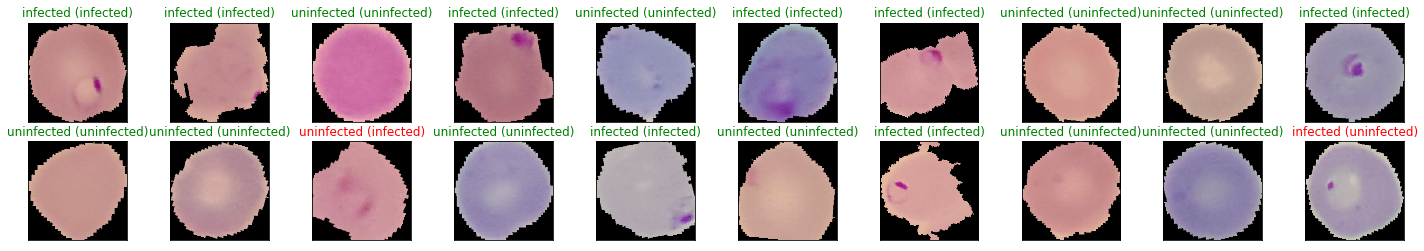

In [34]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Confusion metrix method from https://deeplizard.com/learn/video/0LhiS6yu2qQ

In [35]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

ModuleNotFoundError: No module named 'resources'

In [42]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, f1_score
print(confusion_matrix(actual,predict))
print("Accuracy =",accuracy_score(actual,predict))
print("Precision =",precision_score(actual,predict))
print("Recall =",recall_score(actual,predict))
print("F1 Score =",f1_score(actual,predict))

[[1339   66]
 [  31 1320]]
Accuracy = 0.9648040638606676
Precision = 0.9523809523809523
Recall = 0.9770540340488527
F1 Score = 0.9645597369382535


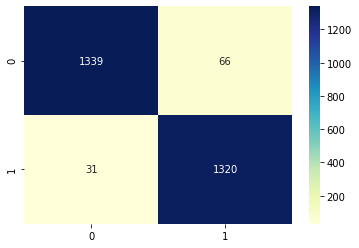

In [49]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(actual,predict)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='YlGnBu')